# Table of contents
1. [Data Prepocessing](#prepocessing)
  
2. [Training a Softmax Linear Classifier](#linear)
  
3. [Training a 2-layer Neural Network](#neural)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# 1. Data Prepocessing 

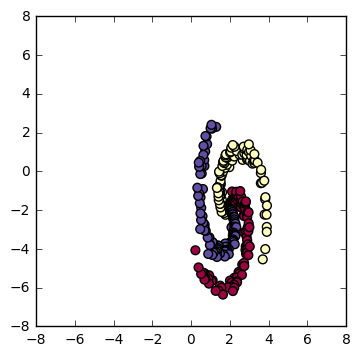

In [3]:
np.random.seed(0)
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D))
y = np.zeros(N*K, dtype='uint8')
for j in range(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0.0,1,N) # radius
    t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
    X[ix] = np.c_[2*r*np.sin(t)+2, 5*r*np.cos(t)-2]
#    theta = -np.pi/6
#    X[ix] = np.c_[5*r*np.cos(t)*np.cos(theta) + 1*r*np.sin(t)*np.sin(theta), \
#                1*r*np.sin(t)*np.cos(theta) - 5*r*np.cos(t)*np.sin(theta)]
    y[ix] = j
fig = plt.figure(figsize=(4,4))
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim([-8,8]);
plt.ylim([-8,8]);
#fig.savefig('spiral_raw.png')

### Mean subtration and normalization

In [4]:
X_prev = np.copy(X)
X -= np.mean(X, axis = 0)
X /= np.std(X, axis = 0)

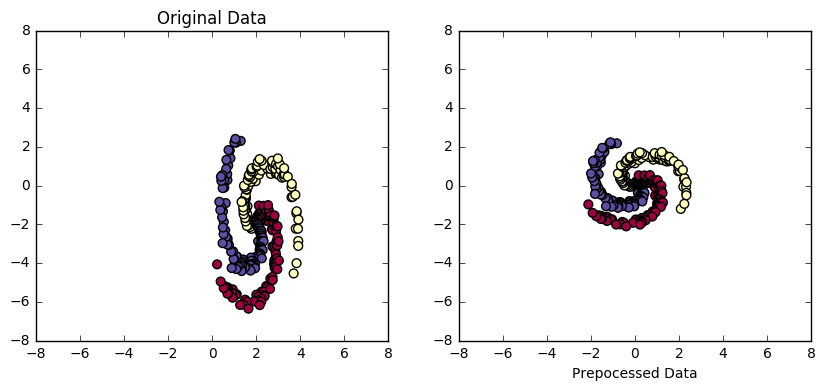

In [5]:
fig = plt.figure(figsize=(10,4))

plt.subplot(1, 2, 1)
plt.scatter(X_prev[:, 0], X_prev[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.title('Original Data')
plt.xlim([-8,8]);
plt.ylim([-8,8]);

plt.subplot(1, 2, 2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlabel('Prepocessed Data')
plt.xlim([-8,8]);
plt.ylim([-8,8]);

plt.show()

### PCA

In [6]:
X_pca = np.hstack((X_prev,X_prev)*25)
X_pca.shape

(300, 100)

In [7]:
# Assume input data matrix X of size [N x D]
X_pca -= np.mean(X_pca, axis = 0) # zero-center the data (important)
X_pca /= np.std(X_pca, axis = 0) # for images, don't need to do this
cov = np.dot(X_pca.T, X_pca) / X_pca.shape[0] # get the data covariance matrix

In [8]:
U,S,V = np.linalg.svd(cov)

In [9]:
print (X_pca.shape, cov.shape)

(300, 100) (100, 100)


In [10]:
print (U.shape, S.shape, V.shape)

(100, 100) (100,) (100, 100)


In [11]:
S[:4]

array([  5.31113083e+01,   4.68886917e+01,   1.28670232e-13,
         8.69431293e-14])

In [12]:
# keeping the 2 dimensions of the data that contain the most variance. 
Xrot = np.dot(X_pca, U) # decorrelate the data
Xrot_reduced = np.dot(X_pca, U[:,:2]) # Xrot_reduced becomes [N x 2]
Xrot_reduced.shape

(300, 2)

### Whitening

The whitening operation takes the data in the eigenbasis and divides every dimension by the eigenvalue to normalize the scale. The geometric interpretation of this transformation is that if the input data is a multivariable gaussian, then the whitened data will be a gaussian with zero mean and identity covariance matrix. 

Warning: Exaggerating noise. Note that we’re adding 1e-5 (or a small constant) to prevent division by zero. One weakness of this transformation is that it can greatly exaggerate the noise in the data, since it stretches all dimensions (including the irrelevant dimensions of tiny variance that are mostly noise) to be of equal size in the input. This can in practice be mitigated by stronger smoothing (i.e. increasing 1e-5 to be a larger number).

In [13]:
# whiten the data:
# divide by the eigenvalues (which are square roots of the singular values)
Xwhite = Xrot / np.sqrt(S + 1e-5)

### In Practice

1. We mention PCA/Whitening in these notes for completeness, but these transformations are not used with Convolutional Networks. However, it is very important to zero-center the data, and it is common to see normalization of every pixel as well.

2. The mean must be computed only over the training data and then subtracted equally from all splits (train/val/test).

# 2.Training a Softmax Linear Classifier

### Visualize Data 

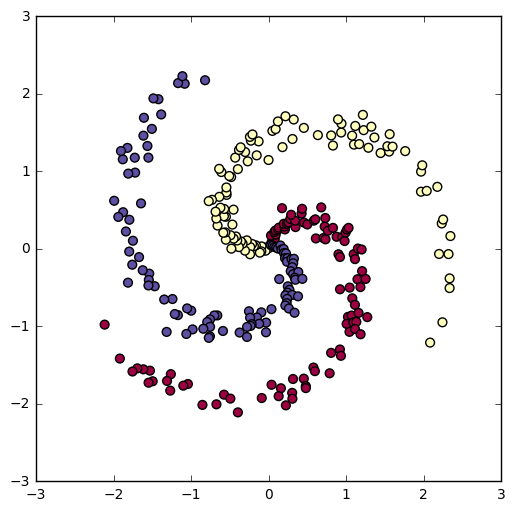

In [16]:
fig = plt.figure(figsize=(6,6))

plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim([-3,3]);
plt.ylim([-3,3]);

plt.show()

### Initialize the parameters

- There is no source of asymmetry between neurons if their weights are initialized to be the same.

- It is common to initialize the weights of the neurons to small numbers and refer to doing so as symmetry breaking

- Calibrating the variances with 1/sqrt(n). w = np.random.randn(n) / sqrt(n), where n is the number of its inputs. This ensures that all neurons in the network initially have approximately the same output distribution and empirically improves the rate of convergence. Not for RELU neurons since the mean is not 0.

- In practice, the current recommendation is to use ReLU units and use the w = np.random.randn(n) * sqrt(2.0/n).

- Sparse initialization.

- Initializing the biases. It is possible and common to initialize the biases to be zero, since the asymmetry breaking is provided by the small random numbers in the weights. 

- Batch Normalization. initializing neural networks by explicitly forcing the activations throughout a network to take on a unit gaussian distribution at the beginning of the training. The core observation is that this is possible because normalization is a simple differentiable operation.

In [17]:
# initialize parameters randomly
W = 0.01 * np.random.randn(D,K)
b = np.zeros((1,K))

### Compute the class scores 

Since this is a linear classifier, we can compute all class scores very simply in parallel with a single matrix multiplication:

In [18]:
# compute class scores for a linear classifier
scores = np.dot(X, W) + b

In [21]:
scores.shape, b.shape

((300, 3), (1, 3))

### Compute the loss 

- [Multiclass Support Vector Machine loss (hinge loss)](http://cs231n.github.io/linear-classify/#loss)

The SVM loss is set up so that the SVM “wants” the correct class for each image to a have a score higher than the incorrect classes by some fixed margin Δ. 

?? Relation to Binary Support Vector Machine. 

- [Softmax classifier](http://cs231n.github.io/linear-classify/#softmax)

Cross-entropy loss: Information theory view & Probabilistic interpretation

In [22]:
# compute the class probabilities
exp_scores = np.exp(scores)
probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]

Practical issues: Numeric stability

In [25]:
np.sum(exp_scores, axis=1).shape, np.sum(exp_scores, axis=1, keepdims=True).shape

((300,), (300, 1))

In [29]:
sta_scores = scores - np.max(scores, axis=1, keepdims=True)

In [30]:
exp_scores = np.exp(sta_scores)
probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]

In [37]:
# 1D arrary of -log probabilities
corect_logprobs = -np.log(probs[range(N*K),y])

In [39]:
# compute the loss: average cross-entropy loss and regularization
num_examples = N*K
data_loss = np.sum(corect_logprobs)/num_examples

In [42]:
data_loss, -np.log(1.0/3)

(1.0945010109970175, 1.0986122886681098)

### Regularization

- L1/L2, Elastic Net Regularization

Neurons with L1 regularization end up using only a sparse subset of their most important inputs and become nearly invariant to the “noisy” inputs. In comparison, final weight vectors from L2 regularization are usually diffuse, small numbers. In practice, if you are not concerned with explicit feature selection, L2 regularization can be expected to give superior performance over L1.

- Max norm constraints

Network cannot “explode” even when the learning rates are set too high because the updates are always bounded.

- Dropout

Dropout is an extremely effective, simple and recently introduced regularization technique by Srivastava et al. in Dropout: A Simple Way to Prevent Neural Networks from Overfitting (pdf) that complements the other methods (L1, L2, maxnorm). While training, dropout is implemented by only keeping a neuron active with some probability pp (a hyperparameter), or setting it to zero otherwise.

In [43]:
""" 
Inverted Dropout: Recommended implementation example.
We drop and scale at train time and don't do anything at test time.
"""

p = 0.5 # probability of keeping a unit active. higher = less dropout

def train_step(X):
    # forward pass for example 3-layer neural network
    H1 = np.maximum(0, np.dot(W1, X) + b1)
    U1 = (np.random.rand(*H1.shape) < p) / p # first dropout mask. Notice /p!
    H1 *= U1 # drop!
    H2 = np.maximum(0, np.dot(W2, H1) + b2)
    U2 = (np.random.rand(*H2.shape) < p) / p # second dropout mask. Notice /p!
    H2 *= U2 # drop!
    out = np.dot(W3, H2) + b3
  
    # backward pass: compute gradients... (not shown)
    # perform parameter update... (not shown)
    
def predict(X):
    # ensembled forward pass
    H1 = np.maximum(0, np.dot(W1, X) + b1) # no scaling necessary
    H2 = np.maximum(0, np.dot(W2, H1) + b2)
    out = np.dot(W3, H2) + b3

In [53]:
np.random.rand(*scores.shape).shape

(300, 3)

In [54]:
# Here we use L2 
reg = 1e-3 # regularization strength
reg_loss = 0.5*reg*np.sum(W*W)
loss = data_loss + reg_loss

In [57]:
reg_loss, data_loss, loss

(2.794672015129854e-07, 1.0945010109970175, 1.0945012904642191)

### Compute the Gradient with Backpropagation (Chain Rule)

# $p_k = \frac{e^{f_k}}{\sum_j e^{f_k}},  \qquad  L_i = -\log (p_{y_i})  \quad \Longrightarrow  \quad \frac{\partial L_i}{\partial f_k} = p_k - \mathbb{1} (y_i = k)$

In [58]:
dscores = probs
dscores[range(num_examples),y] -= 1
dscores /= num_examples

In [59]:
dW = np.dot(X.T, dscores)
db = np.sum(dscores, axis=0, keepdims=True) # note: + b for every class
dW += reg*W # don't forget the regularization gradient

### Update Parameter: Gradient Descent

- [Gradient Checks](http://cs231n.github.io/neural-networks-3/#gradcheck): analytical VS numerical,
  - central difference formula, h ~ 1e-5
  - relative error for comparison
  - double precision ??
  - kinks: few datapoints
  - check only few dimensions

- Sanity Checks:
  - look for correct loss at chance performance without regulariztion
  - overfit a tiny subset of data to achieve zero cost
  - increasing the regularization strength should increase the loss


In [60]:
# perform a parameter update
step_size = 1e-0
W += -step_size * dW
b += -step_size * db

- Learning Rate: 
  - Ratio of weights: A rough heuristic is that this ratio should be somewhere around 1e-3. If it is lower than this then the learning rate might be too low. If it is higher then the learning rate is likely too high. Here is a specific example:
  - Step decay: Reduce the learning rate by some factor every few epochs. Typical values might be reducing the learning rate by a half every 5 epochs, or by 0.1 every 20 epochs.
  - Exponential decay: has the mathematical form $\alpha = \alpha_0 e^{-kt}$, where t is the iteration number (but you can also use units of epochs).
  - 1/t decay: has the mathematical form $\alpha = \alpha_0/ (1 +kt)$ 

In [63]:
# assume parameter vector W and its gradient vector dW
learning_rate = 1e-1
param_scale = np.linalg.norm(W.ravel())
update = -learning_rate*dW # simple SGD update
update_scale = np.linalg.norm(update.ravel())
W += update # the actual update
print (update_scale / param_scale) # want ~1e-3

0.049411228421


### Stochastic  Gradient Descent

- Momentum

In [64]:
v = 0*dW
mu = 0.9
v = mu * v - learning_rate * dW # integrate velocity
W += v # integrate position

In [65]:
x, dx = W, dW

- Nesterov Momentum 

In [67]:
x_ahead = x + mu * v
# evaluate dx_ahead (the gradient at x_ahead instead of at x), 
dx_ahead = 2*dx # for simplity:
v = mu * v - learning_rate * dx_ahead
x += v

In [68]:
# alternate form:
v_prev = v # back this up
v = mu * v - learning_rate * dx # velocity update stays the same
x += -mu * v_prev + (1 + mu) * v # position update changes form

- Newton's method:      
$ \qquad x  \leftarrow x - [H f(x)]^{-1} \nabla f(x)$

- Adagrad

In [71]:
# Assume the gradient dx and parameter vector x
cache = 0
eps = 1e-6
cache += dx**2
x += - learning_rate * dx / (np.sqrt(cache) + eps)

- RMSprop

In [72]:
decay_rate = 0.9
cache = decay_rate * cache + (1 - decay_rate) * dx**2
x += - learning_rate * dx / (np.sqrt(cache) + eps)

 - Adam

In [77]:
eps = 1e-8
beta1 = 0.9
beta2 = 0.999
m, v = 0, 0
m = beta1*m + (1-beta1)*dx
v = beta2*v + (1-beta2)*(dx**2)
x += - learning_rate * m / (np.sqrt(v) + eps)

### Put it all together: Training a Softmax Classifier

In [81]:
#Train a Linear Classifier

# initialize parameters randomly
W = 0.01 * np.random.randn(D,K)
b = np.zeros((1,K))

# some hyperparameters
step_size = 1e-0
reg = 1e-3 # regularization strength

# gradient descent loop
num_examples = X.shape[0]
for i in range(200):
  
    # evaluate class scores, [N x K]
    scores = np.dot(X, W) + b 
  
    # compute the class probabilities
    exp_scores = np.exp(scores)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]
  
    # compute the loss: average cross-entropy loss and regularization
    corect_logprobs = -np.log(probs[range(num_examples),y])
    data_loss = np.sum(corect_logprobs)/num_examples
    reg_loss = 0.5*reg*np.sum(W*W)
    loss = data_loss + reg_loss
    if i % 10 == 0:
        print ("iteration %d: loss %f" % (i, loss))
  
     # compute the gradient on scores
    dscores = probs
    dscores[range(num_examples),y] -= 1
    dscores /= num_examples
  
    # backpropate the gradient to the parameters (W,b)
    dW = np.dot(X.T, dscores)
    db = np.sum(dscores, axis=0, keepdims=True)
  
    dW += reg*W # regularization gradient
  
    # perform a parameter update
    W += -step_size * dW
    b += -step_size * db

iteration 0: loss 1.097940
iteration 10: loss 0.785759
iteration 20: loss 0.778305
iteration 30: loss 0.777421
iteration 40: loss 0.777274
iteration 50: loss 0.777247
iteration 60: loss 0.777242
iteration 70: loss 0.777240
iteration 80: loss 0.777240
iteration 90: loss 0.777240
iteration 100: loss 0.777240
iteration 110: loss 0.777240
iteration 120: loss 0.777240
iteration 130: loss 0.777240
iteration 140: loss 0.777240
iteration 150: loss 0.777240
iteration 160: loss 0.777240
iteration 170: loss 0.777240
iteration 180: loss 0.777240
iteration 190: loss 0.777240


In [83]:
# evaluate training set accuracy
scores = np.dot(X, W) + b
predicted_class = np.argmax(scores, axis=1)
print ('training accuracy: %.2f' % (np.mean(predicted_class == y)))

training accuracy: 0.49


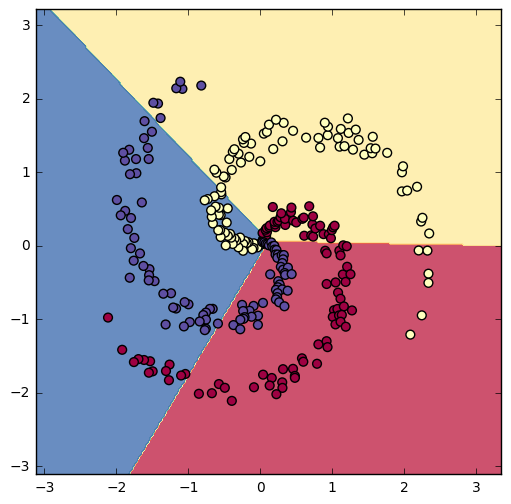

In [87]:
# plot the resulting classifier
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = np.dot(np.c_[xx.ravel(), yy.ravel()], W) + b
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)
fig = plt.figure(figsize=(6,6))
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max());
plt.ylim(yy.min(), yy.max());
#fig.savefig('spiral_linear.png')